# Practice 1: Data Science Salaries
In this practice assignment I looked at the Diabetes prediction dataset provided by Mohammed Mustafa on [kaggle](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) and predicted the diabetes. 

The following questions will be anwsered in this document:
* What is unbalanced data?
* What is a ROC curve?
* WHat is the impact of unbalanced data on the results and how to mitigate it?
* What is the implication of using the random sampler, should it be sampled before or after dividing the data into a train and test set?
* What happens if the model trained on the sampled data is applied on the entire dataset?

## Made By Jarno Weemen

In [56]:
# Neccessary
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline

# sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline

In [2]:
df_diabetes = pd.read_csv("Data/diabetes_prediction_dataset.csv")
df_diabetes.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


# Looking at data
First of all lets take a quick look at the data to see if it needs cleaning.

In [3]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


There doesn't seem to be any values that are null or have a weird data type.

In [4]:
for col in df_diabetes.columns:
    print("Col: {}, Unique values: {}".format(col, df_diabetes[col].unique()))

Col: gender, Unique values: ['Female' 'Male' 'Other']
Col: age, Unique values: [80.   54.   28.   36.   76.   20.   44.   79.   42.   32.   53.   78.
 67.   15.   37.   40.    5.   69.   72.    4.   30.   45.   43.   50.
 41.   26.   34.   73.   77.   66.   29.   60.   38.    3.   57.   74.
 19.   46.   21.   59.   27.   13.   56.    2.    7.   11.    6.   55.
  9.   62.   47.   12.   68.   75.   22.   58.   18.   24.   17.   25.
  0.08 33.   16.   61.   31.    8.   49.   39.   65.   14.   70.    0.56
 48.   51.   71.    0.88 64.   63.   52.    0.16 10.   35.   23.    0.64
  1.16  1.64  0.72  1.88  1.32  0.8   1.24  1.    1.8   0.48  1.56  1.08
  0.24  1.4   0.4   0.32  1.72  1.48]
Col: hypertension, Unique values: [0 1]
Col: heart_disease, Unique values: [1 0]
Col: smoking_history, Unique values: ['never' 'No Info' 'current' 'former' 'ever' 'not current']
Col: bmi, Unique values: [25.19 27.32 23.45 ... 59.42 44.39 60.52]
Col: HbA1c_level, Unique values: [6.6 5.7 5.  4.8 6.5 6.1 6.  5.

All of the unique values also look good, even the age where you have . values, because a baby of 1 week and 50 weeks is already quite the difference.

# Analysing the data
Now that we know the data is ready for use, we can look at a couple of things:
* Features of people with and without diabetes.
* Potential outliers.
* Corrolation

In [5]:
df_diabetes.describe()

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,41.885856,0.07485,0.039420,27.320767,5.527507,138.058060,0.085000
std,22.516840,0.26315,0.194593,6.636783,1.070672,40.708136,0.278883
min,0.080000,0.00000,0.000000,10.010000,3.500000,80.000000,0.000000
25%,24.000000,0.00000,0.000000,23.630000,4.800000,100.000000,0.000000
50%,43.000000,0.00000,0.000000,27.320000,5.800000,140.000000,0.000000
75%,60.000000,0.00000,0.000000,29.580000,6.200000,159.000000,0.000000
max,80.000000,1.00000,1.000000,95.690000,9.000000,300.000000,1.000000


In [6]:
# Creating 2 dataframes where one is people with diabetes and the other is without.
df_diabetes_true = df_diabetes.loc[df_diabetes["diabetes"] == 1]
df_diabetes_false = df_diabetes.loc[df_diabetes["diabetes"] == 0]

In [7]:
print("True: {}".format(df_diabetes_true.shape))
print("False: {}".format(df_diabetes_false.shape))

True: (8500, 9)
False: (91500, 9)


As you can see the difference between people who have and don't have diabetes is huge. This could already imply that sampling is necessary at the modelling stage. 

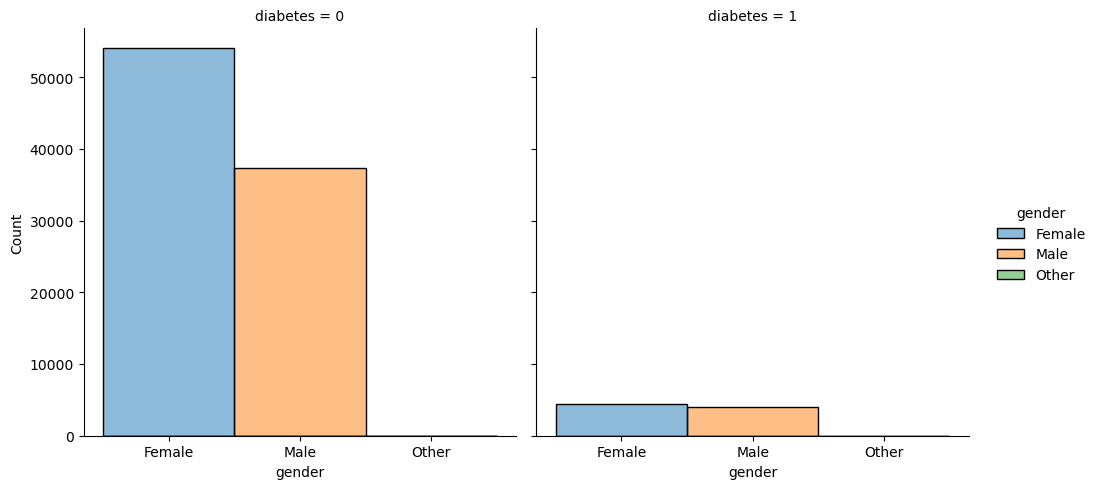

In [8]:
sns.displot(data=df_diabetes, x="gender", col="diabetes", hue="gender")
plt.show()

Whether gender has an impact on having diabetes or not, is a bit hard to say, because the count of non-diabetics isn't equal for females and males.

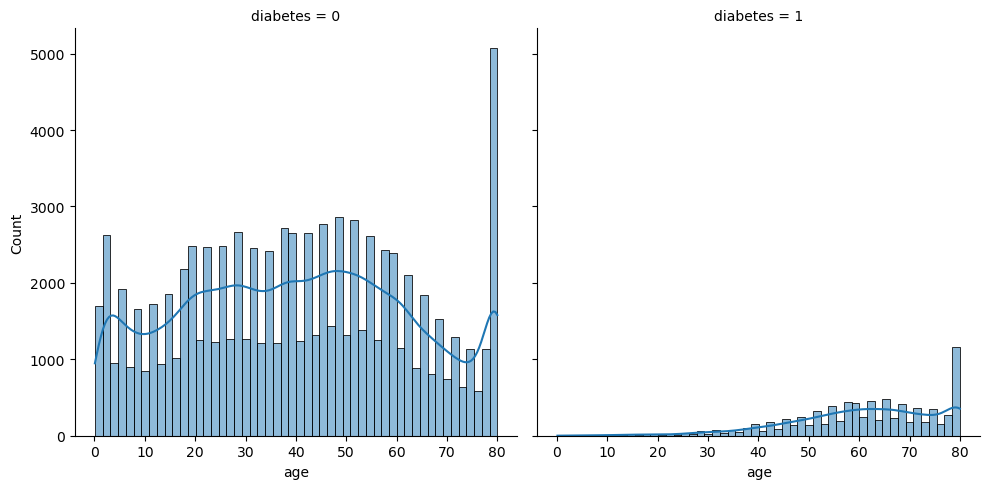

In [9]:
sns.displot(data=df_diabetes,x="age", col="diabetes",kde=True)
plt.show()

Most people from this dataset are around 80 years old, but it also shows that the older you get, the more likely you get diabetes, starting around 40 years old.

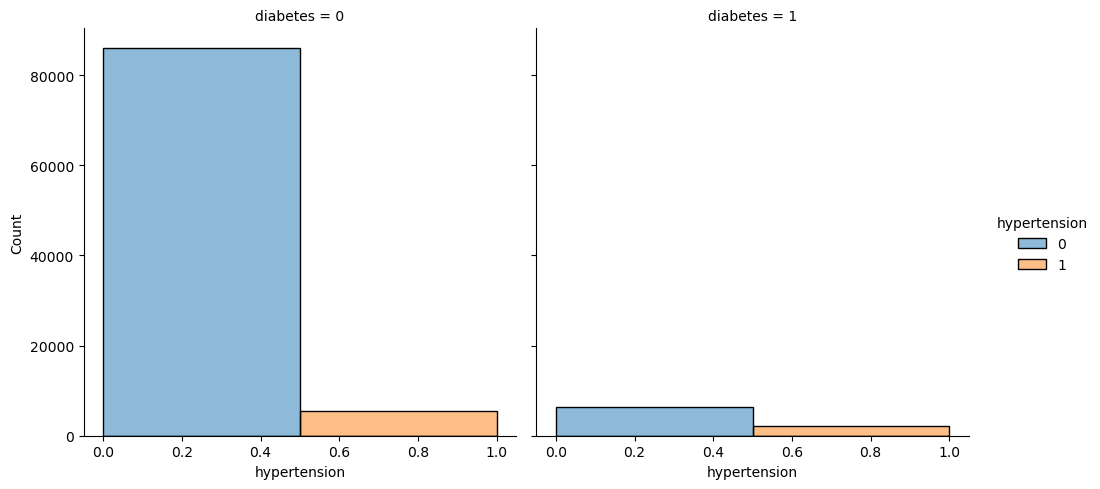

In [10]:
sns.displot(data=df_diabetes, x="hypertension", col="diabetes", bins=[0,0.5,1], hue="hypertension")
plt.show()

Hypertension doesn't look to be a problem in this chart.

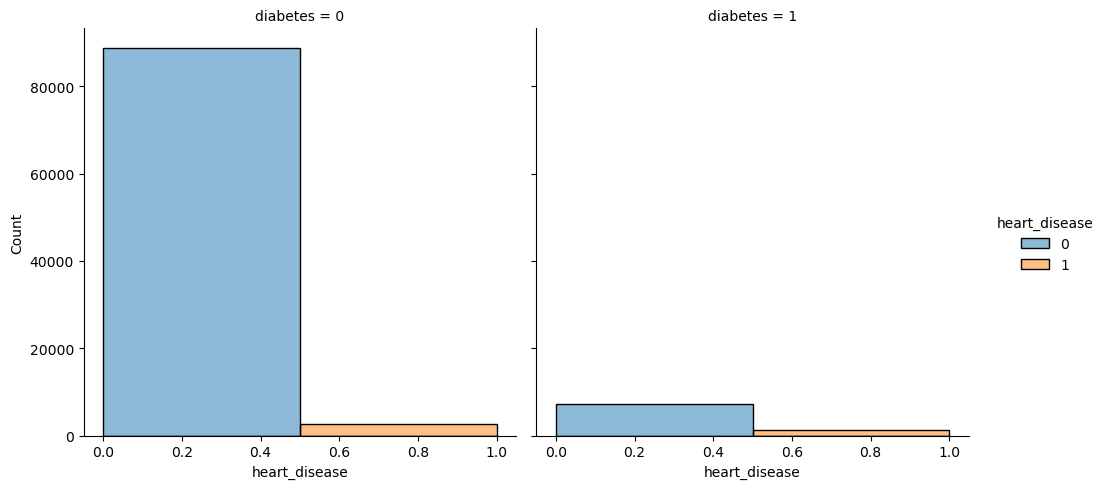

In [11]:
sns.displot(data=df_diabetes, x="heart_disease", col="diabetes", bins=[0,0.5,1], hue="heart_disease")
plt.show()

Same goes for heart disease.

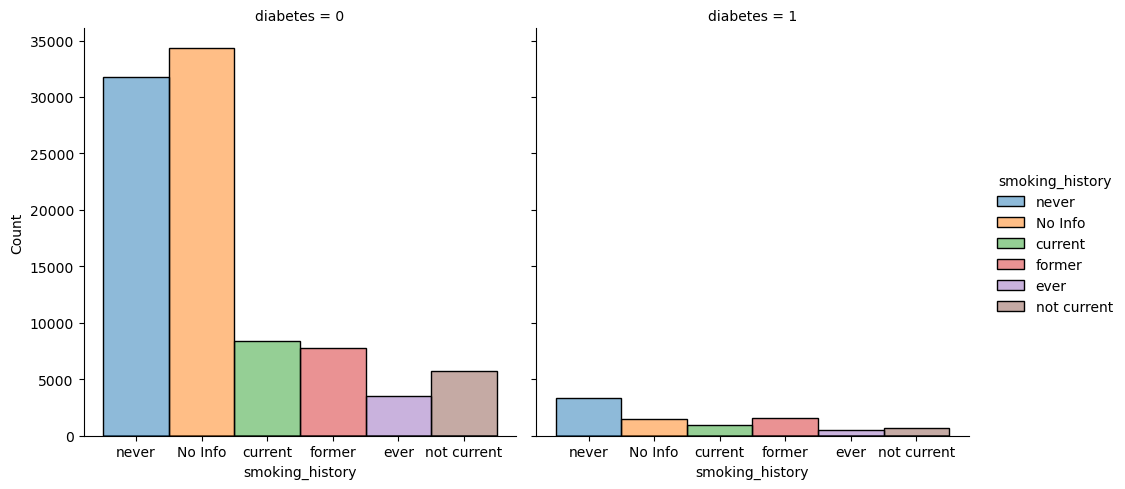

In [12]:
sns.displot(data=df_diabetes, x="smoking_history", col="diabetes", hue="smoking_history")
plt.show()

Having a former history of smoking might impact chances of diabetes, its a bit hard to say though.

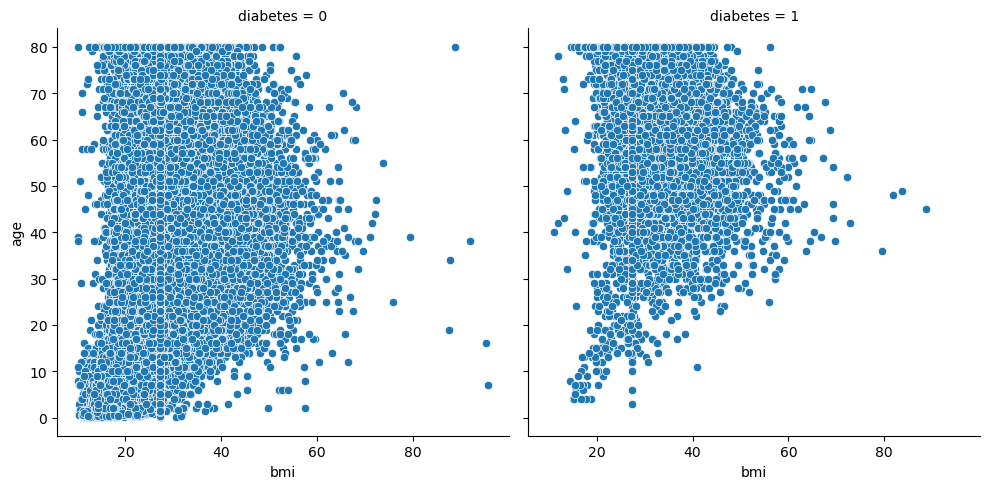

In [13]:
sns.relplot(data=df_diabetes, x="bmi", y="age",col="diabetes")
plt.show()

BMI definitly has some outliers, but it also doesn't necessarely indicate a higher chance of being diabetic.

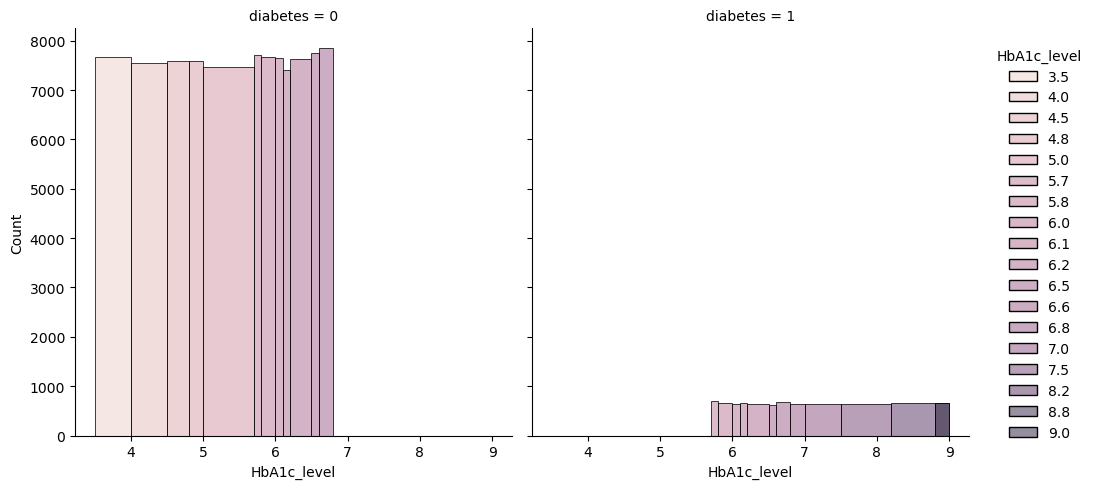

In [112]:
bins_arr = []
for unique in df_diabetes["HbA1c_level"].unique():
    bins_arr.append(unique)

bins_arr.sort()

sns.displot(data=df_diabetes, x="HbA1c_level",bins=bins_arr, col="diabetes", hue="HbA1c_level")
plt.show()

Your Hba1c level clearly shows whether you have diabetese or not, atleast when it's over around 225.

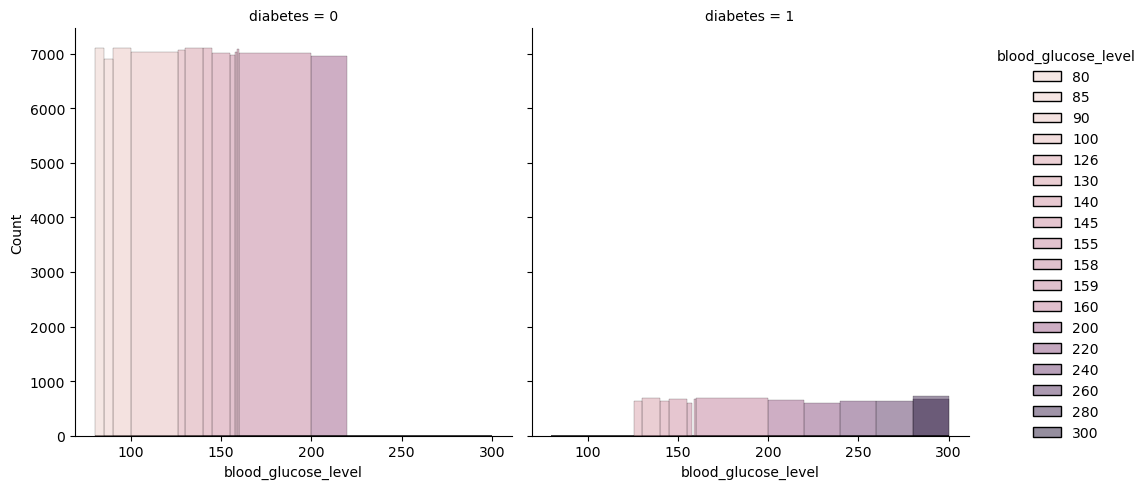

In [15]:
bins_arr = []
for unique in df_diabetes["blood_glucose_level"].unique():
    bins_arr.append(unique)

bins_arr.sort()

sns.displot(data=df_diabetes, x="blood_glucose_level", bins=bins_arr,col="diabetes", hue="blood_glucose_level")
plt.show()

Blood glucose level shows the exact same, but starting at around 225 you can clearly tell you have diabetes.

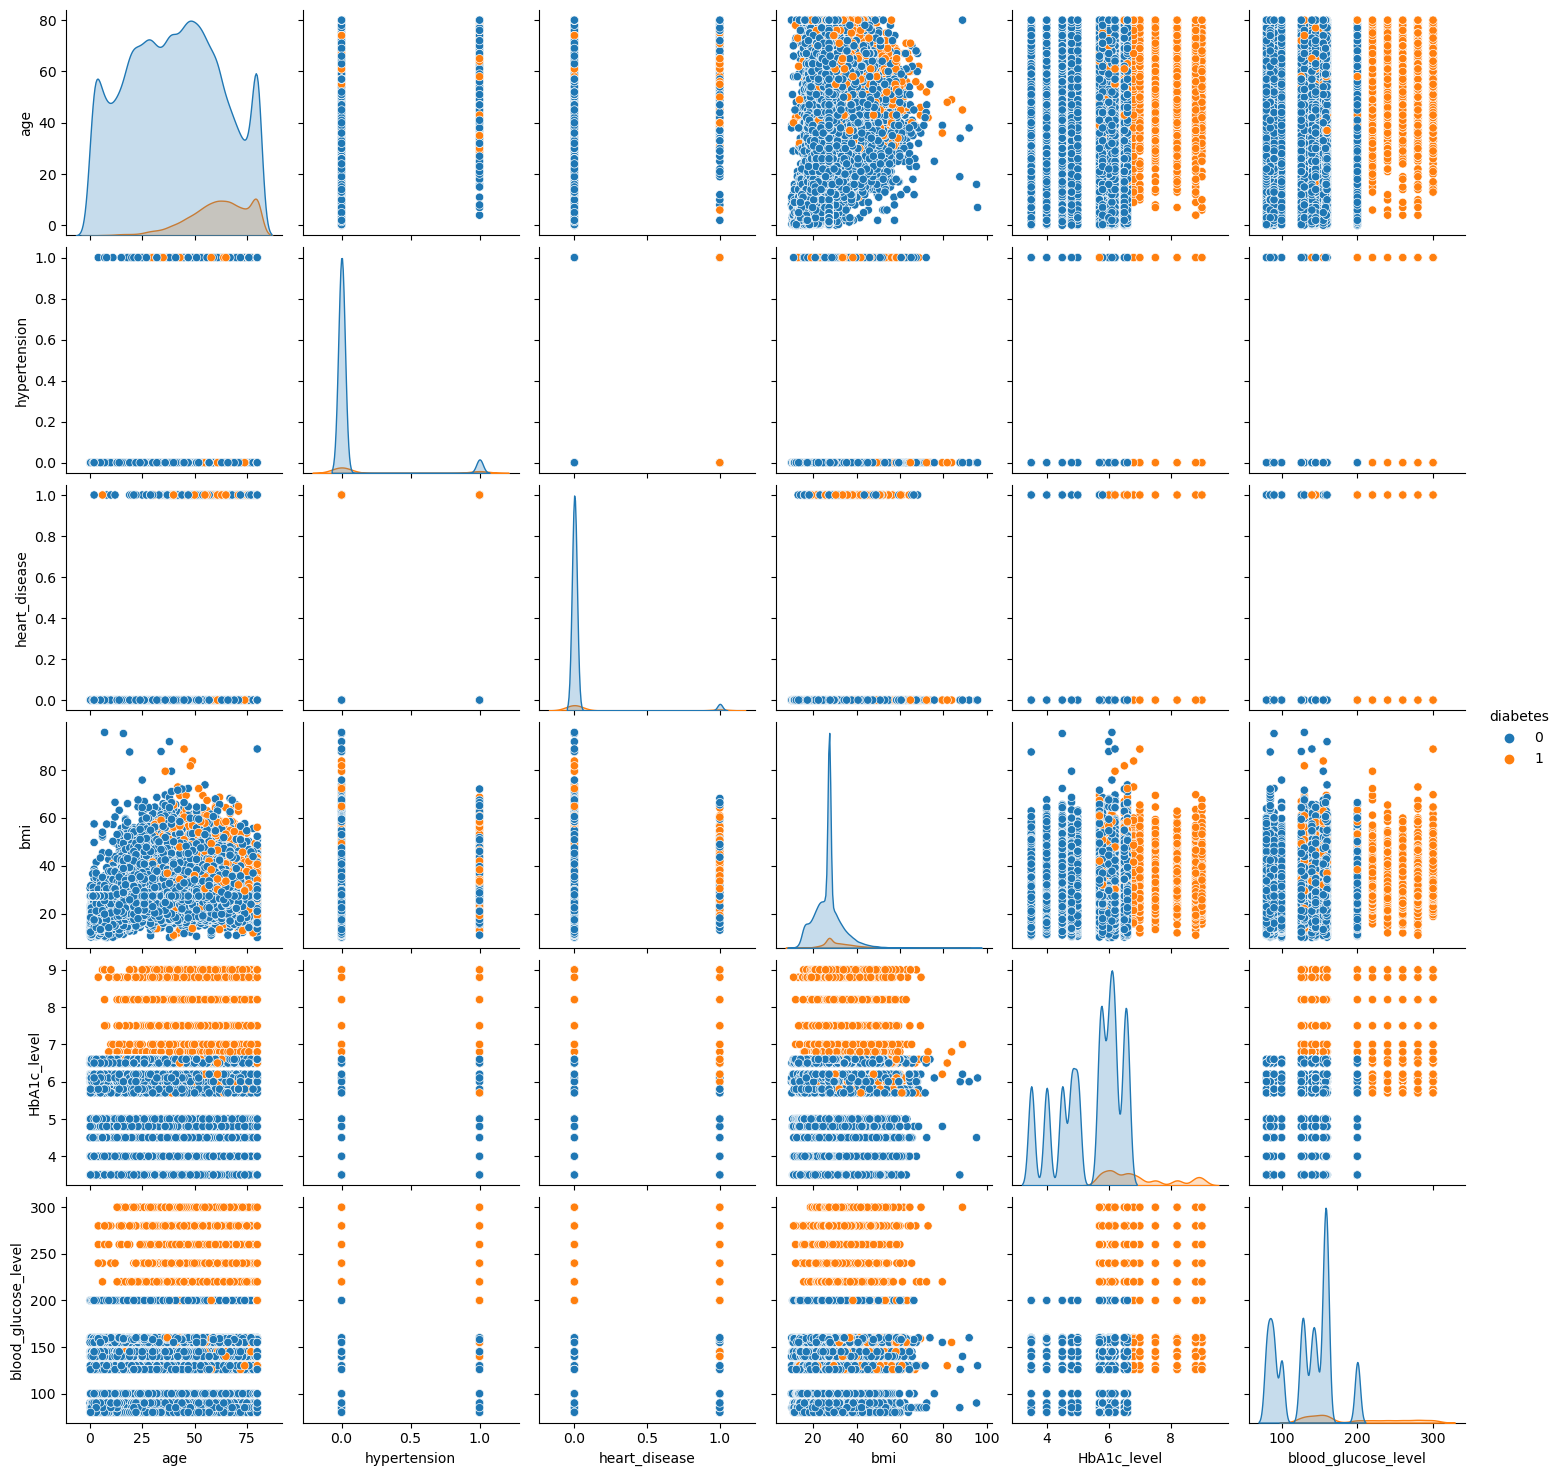

In [16]:
sns.pairplot(df_diabetes, hue='diabetes')
plt.show()

In this pairplot you can clearly see that higher numbers on almost all, if not all categories increase the chance of diabetes. Even BMI now shows much more clearly that being above 30 can increase your chances.

In [113]:
# Generalizing smoking column
def recategorize_smoking(smoking_status):
    if smoking_status in ['never']:
        return 'non-smoker'
    elif smoking_status in ['No Info']:
        return 'no_info'
    elif smoking_status == 'current':
        return 'current'
    elif smoking_status in ['ever', 'former', 'not current']:
        return 'past_smoker'

df_diabetes['smoking_history'] = df_diabetes['smoking_history'].apply(recategorize_smoking)
print(df_diabetes['smoking_history'].value_counts())

current    9286
Name: smoking_history, dtype: int64


In [18]:
# Copying because need the diabetes dataframe for modeling.
data = df_diabetes.copy()

In [19]:
# Onehotencoding for correlation matrix.
def perform_one_hot_encoding(data, column_names):
    enc=OneHotEncoder()    
    enc_data = pd.DataFrame(enc.fit_transform(data[column_names]).toarray())
    enc_data.columns = enc.get_feature_names_out()
    
    data = pd.concat([data.drop(column_names, axis=1), enc_data], axis=1)

    return data

data = perform_one_hot_encoding(data, ['gender', 'smoking_history'])
data.head(10)

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,diabetes,gender_Female,gender_Male,gender_Other,smoking_history_current,smoking_history_no_info,smoking_history_non-smoker,smoking_history_past_smoker
0,80.0,0,1,25.19,6.6,140,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,54.0,0,0,27.32,6.6,80,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,28.0,0,0,27.32,5.7,158,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,36.0,0,0,23.45,5.0,155,0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,76.0,1,1,20.14,4.8,155,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
5,20.0,0,0,27.32,6.6,85,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
6,44.0,0,0,19.31,6.5,200,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0
7,79.0,0,0,23.86,5.7,85,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,42.0,0,0,33.64,4.8,145,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,32.0,0,0,27.32,5.0,100,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
corr_matrix = data.corr()

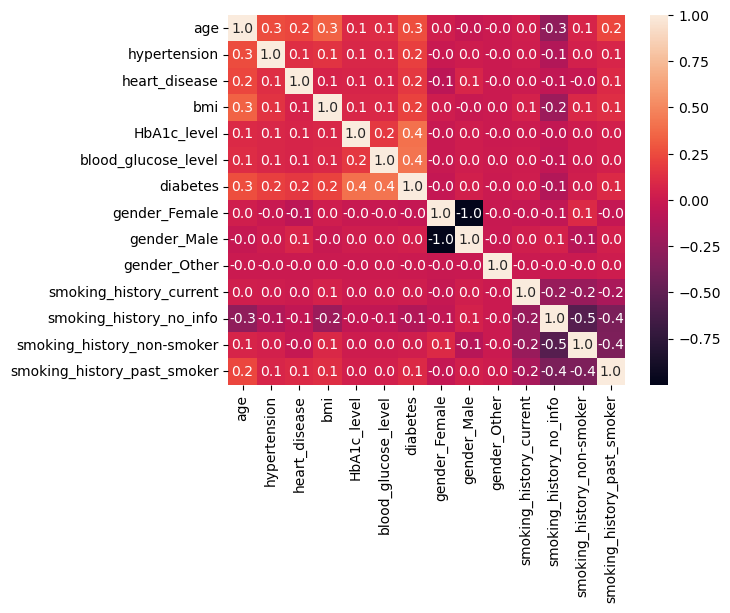

In [21]:
sns.heatmap(corr_matrix, annot=True, fmt=".1f")
plt.show()

This heatmap shows that diabetes correlates the most with blood glucose and HbA1c, which is what the previous charts pretty much concluded, because of the obvious difference in non-diabetics and diabetics.

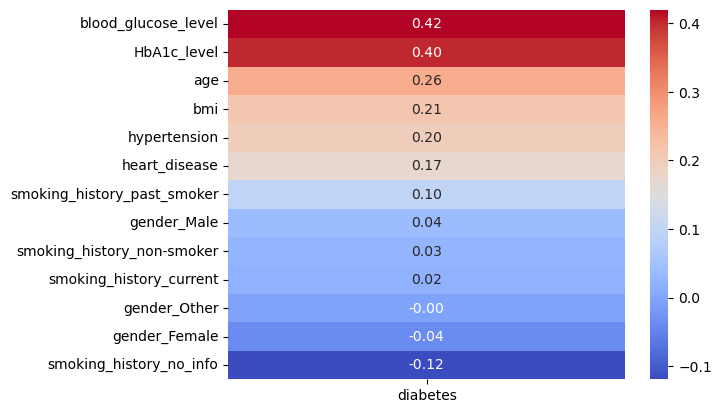

In [22]:
target_corr = corr_matrix['diabetes'].drop('diabetes')
target_corr_sorted = target_corr.sort_values(ascending=False)
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f')
plt.show()

# Modeling

## Without sampler
First I modeled with a DTC and RFC without using a sampler to see what the results would be.

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

X = df_diabetes.drop('diabetes', axis=1)
y = df_diabetes['diabetes']

### DecisionTreeClassifier

In [69]:
clf_DTC_no_sampler = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

X = df_diabetes.drop('diabetes', axis=1)
y = df_diabetes['diabetes']

In [70]:
param_grid = {
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [71]:
grid_search = GridSearchCV(clf_DTC_no_sampler, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 10}


In [72]:
y_pred = grid_search.predict(X_test)

print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model Accuracy:  0.9718
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18292
           1       0.98      0.69      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.97      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



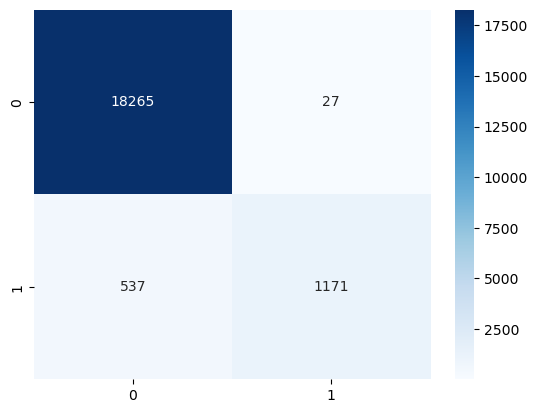

In [73]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

### RandomForestClassifier

In [74]:
clf_RFC_no_sampler = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

In [75]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [76]:
grid_search = GridSearchCV(clf_RFC_no_sampler, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': None, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 200}


In [77]:
y_pred = grid_search.predict(X_test)

print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model Accuracy:  0.97245
              precision    recall  f1-score   support

           0       0.97      1.00      0.99     18292
           1       1.00      0.68      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.98      0.84      0.90     20000
weighted avg       0.97      0.97      0.97     20000



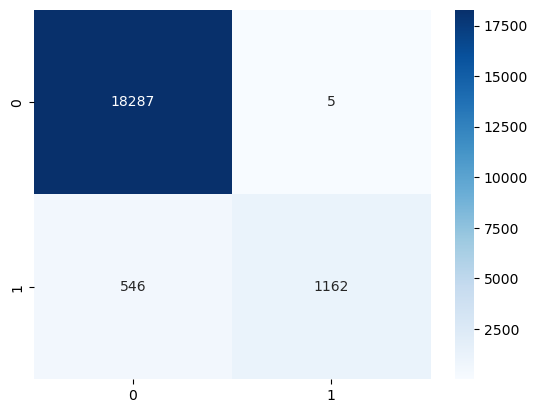

In [78]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

## With sampler

In [155]:
over = SMOTE(sampling_strategy=0.1) # DTC = 0.96105
# over = SMOTE(sampling_strategy=0.3) # DTC = 0.95755
# under = RandomUnderSampler(sampling_strategy=0.1) # DTC = 0.97205, RFC = 0.97225
under = RandomUnderSampler(sampling_strategy=0.3) # DTC = 0.96105, RFC = 0.9702
# under = RandomUnderSampler(sampling_strategy=0.5) # DTC = 0.0.94105, RFC = 0.9568

In [156]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level','hypertension','heart_disease']),
        ('cat', OneHotEncoder(), ['gender','smoking_history'])
    ])

X = df_diabetes.drop('diabetes', axis=1)
y = df_diabetes['diabetes']

### DecisionTreeClassifier

In [157]:
clf_DTC = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', DecisionTreeClassifier())])

In [158]:
param_grid = {
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [159]:
grid_search = GridSearchCV(clf_DTC, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}


In [160]:
y_pred = grid_search.predict(X_test)

print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model Accuracy:  0.96105
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     18292
           1       0.78      0.77      0.77      1708

    accuracy                           0.96     20000
   macro avg       0.88      0.87      0.87     20000
weighted avg       0.96      0.96      0.96     20000



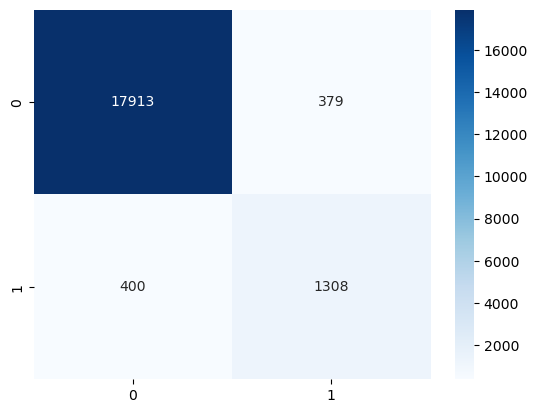

In [167]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

### RandomForestClassifier

In [117]:
clf_RFC = imbPipeline(steps=[('preprocessor', preprocessor),
                      ('over', over),
                      ('under', under),
                      ('classifier', RandomForestClassifier())])

In [118]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

In [119]:
grid_search = GridSearchCV(clf_RFC, param_grid, cv=5)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


In [120]:
y_pred = grid_search.predict(X_test)

print("Model Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Model Accuracy:  0.9702
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18292
           1       0.91      0.72      0.81      1708

    accuracy                           0.97     20000
   macro avg       0.94      0.86      0.89     20000
weighted avg       0.97      0.97      0.97     20000



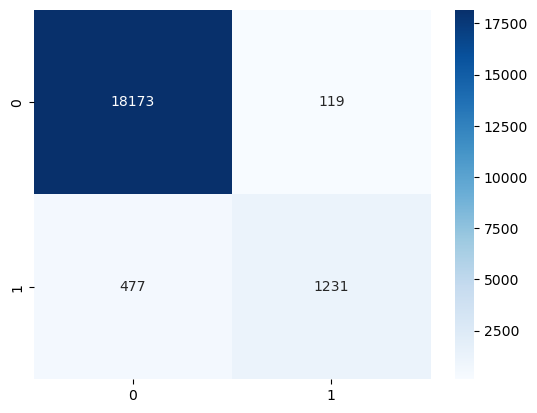

In [122]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

In [40]:
onehot_columns = list(grid_search.best_estimator_.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(['gender', 'smoking_history']))

feature_names = ['age', 'BMI', 'HbA1c_level', 'blood_glucose_level', 'hypertension', 'heart_disease'] + onehot_columns

importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values('Importance', ascending=False)

print(importance_df)

                        Feature  Importance
2                   HbA1c_level    0.434463
3           blood_glucose_level    0.303791
0                           age    0.124629
1                           BMI    0.069379
4                  hypertension    0.033432
5                 heart_disease    0.017533
10      smoking_history_no_info    0.008640
12  smoking_history_past_smoker    0.003139
7                   gender_Male    0.001744
6                 gender_Female    0.001340
11   smoking_history_non-smoker    0.001012
9       smoking_history_current    0.000898
8                  gender_Other    0.000001


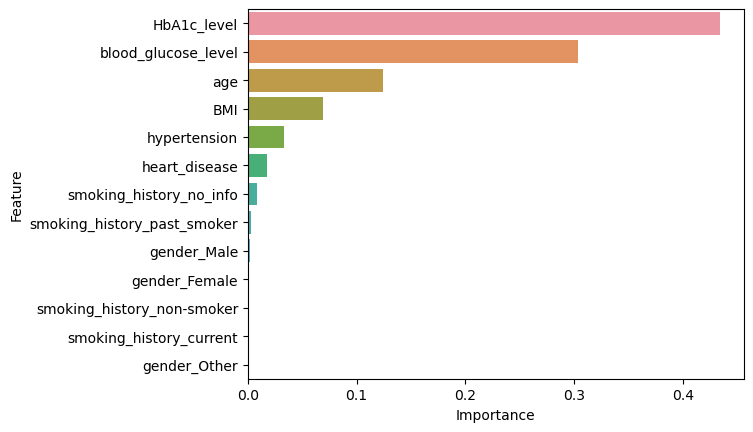

In [41]:
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.show()

## ROC Curve